<div class="alert alert-block alert-info">
    
<h1 style="color:Blue;"> <center> <ins> <b> 
Métodos Numéricos - Projeto Final 
</b> </ins> </center> </h1>
    
<h3 style="color:Blue;"> <center> <b> 
Análise de Imagens de Tomografia Computadorizada de Pulmões - Projeto completo
</b></center> </h3>

<h3 style="color:Blue;"> <center> <b> 
Jhonatan Pereira</b></center> </h3>
    
</div>

<div class="alert alert-block alert-info" style="color:Blue;" id="descricao">
Descrição do Projeto
</div>

Nessa parte do projeto final, vocês usarão parte do que aprenderam para fazer uma análise completa usando processamento de imagens de pulmões, basicamente com o uso das bibliotecas com as quais lidamos nas partes anteriores.

A tarefa aqui é bem simples: executar, logicamente inserindo os comentários sobre os resultados obitidos e os códigos associados, o tutorial intitulado [Introduction to medical image processing with Python: CT lung and vessel segmentation without labels](https://theaisummer.com/medical-image-python/).



In [2]:
import os
import csv
import glob
import shutil
import numpy as np
import nibabel as nib
from skimage import measure
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull

In [3]:
def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")


def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)
    
def make_dirs(path):
    """
    Creates the directory as specified from the path
    in case it exists it deletes it
    """
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area

    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours


def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()



def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')


def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that get the pixdim indicated from the image
    dimensions. From the last 2 image dimensions we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"]
    dim = ct_img.header["dim"]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

Images found: 21


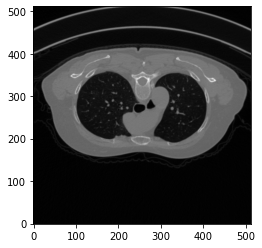

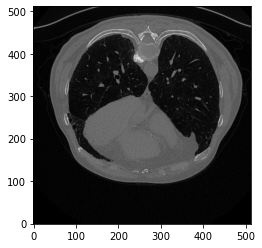

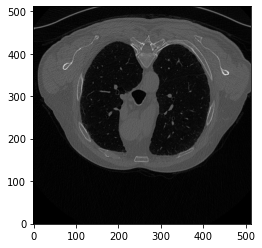

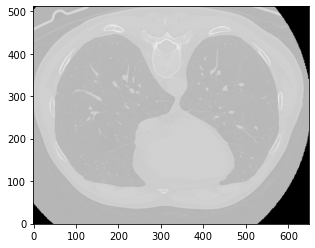

In [6]:
basepath = '../datasets/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata()
    show_slice(ct_numpy)
    if c == 3:
      break

slice001 lung area: 14218.815117879074
slice002 lung area: 34572.27296447754
slice003 lung area: 31513.963623046875
slice004 lung area: 33388.04453495125
slice005 lung area: 32391.739428426652
slice006 lung area: 32086.478447489502
slice007 lung area: 17640.84075957298
slice008 lung area: 26042.239642517397
slice009 lung area: 31255.91289323208
slice010 lung area: 24475.454391479492
slice011 lung area: 18455.89931488037
slice012 lung area: 25330.21658706665
slice013 lung area: 30042.837661743164
slice014 lung area: 30310.75862121582
slice015 lung area: 25977.577117919922
slice016 lung area: 27387.329864501953
slice017 lung area: 15523.084259033203
slice018 lung area: 29196.441650390625
slice019 lung area: 4298.816299438477
slice020 lung area: 12907.887268066406


/tmp/ipykernel_7577/3831899960.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/tmp/ipykernel_7577/3831899960.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


slice021 lung area: 11454.214477539062


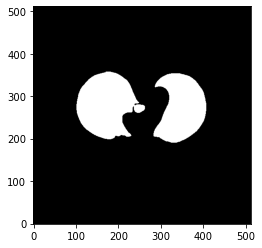

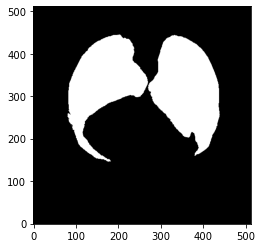

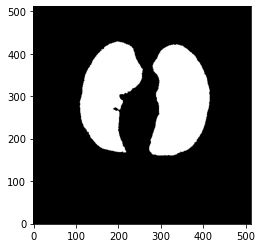

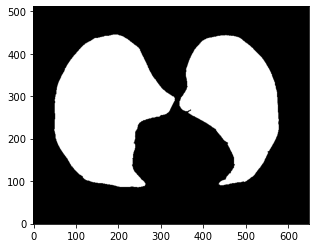

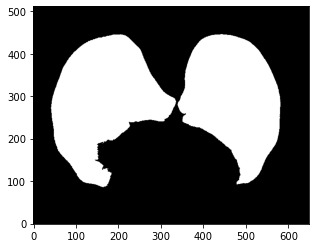

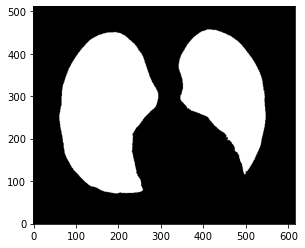

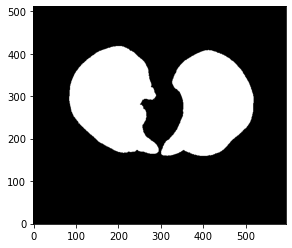

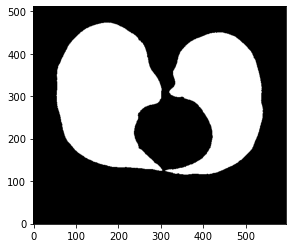

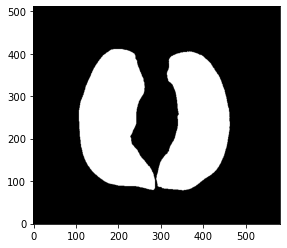

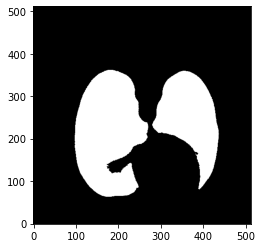

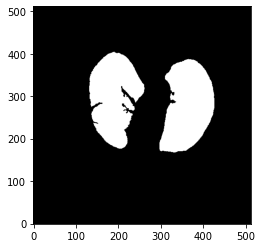

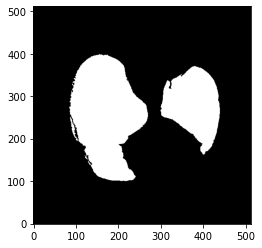

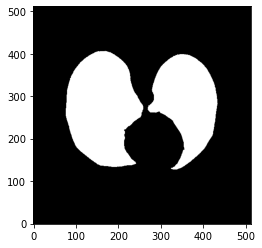

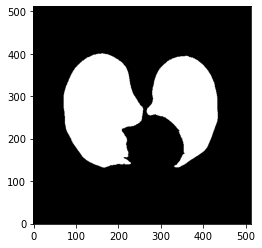

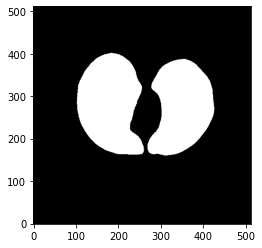

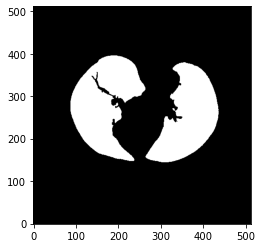

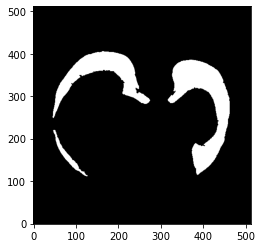

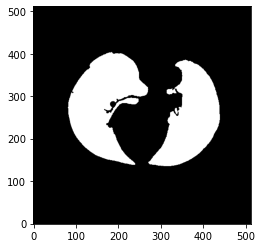

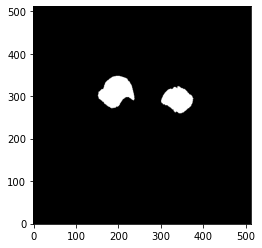

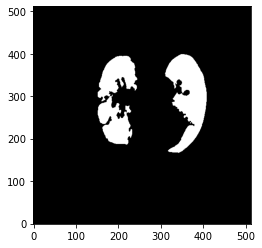

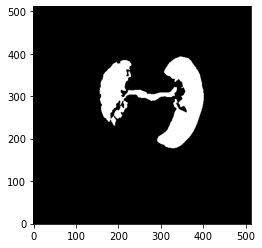

In [7]:
outpath = './LUNGS/'
contour_path = './Contours/'
paths = sorted(glob.glob(basepath))
myFile = open('lung_volumes.csv', 'w')
lung_areas = []
make_dirs(outpath)
make_dirs(contour_path)

for c, exam_path in enumerate(paths):
    # Leitura dos arquivos
    img_name = exam_path.split("/")[-1].split('.nii')[0].split('\\')[-1]
    
    # Nome e caminhos dos arquivos a serem salvos
    out_mask_name = outpath + img_name + "_mask"
    contour_name = contour_path + img_name + "_contour"

    ct_img = nib.load(exam_path)

    # Gerar dimenções do pulmão em mm² (valores de x e y)
    pixdim = find_pix_dim(ct_img)
    
    ct_numpy = ct_img.get_fdata()

    # Analizar e obter os contornos da imagem para cada item presente
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)

    # Escolher os contornos referente aos pulmões
    lungs = find_lungs(contours)
    
    # Salva as imagens com os seus contornos
    show_contour(ct_numpy, lungs, contour_name,save=True)
    
    # Cria uma máscara de polígonos
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    # Salva as imagens em formato .nii
    save_nifty(lung_mask, out_mask_name, ct_img.affine)
    show_slice(lung_mask)

    # Analize dos vasos

    # Calcular a área dos vasos
    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))
    lung_areas.append([img_name,lung_area]) # int is ok since the units are already mm^2
    
    # Área de cada vaso
    print(img_name,'lung area:', lung_area)

# Salva os dados em CSV
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas)

Specify denoise=False in create_vessel_mask for quick and noisy results.
Otherwise wait a couple of minutes :)
slice001 Vessel %: 2.2451221087995865
slice002 Vessel %: 3.6643426472423815
slice003 Vessel %: 2.323943661971831
slice004 Vessel %: 2.712665648385968
slice005 Vessel %: 2.2762854680106246
slice006 Vessel %: 3.126406404105982
slice007 Vessel %: 2.9513865438385585
slice008 Vessel %: 3.808181826499894


KeyboardInterrupt: 

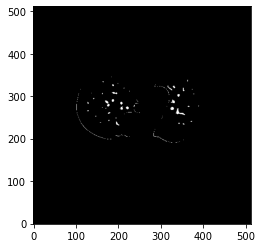

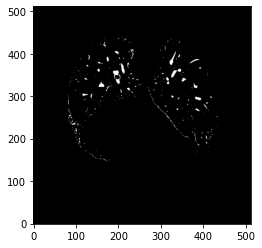

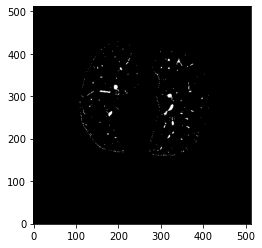

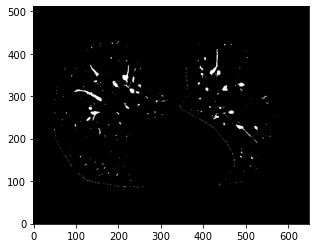

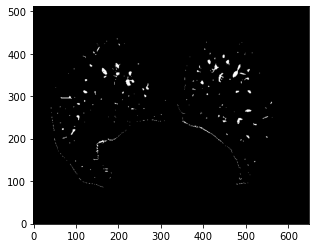

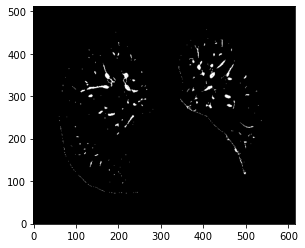

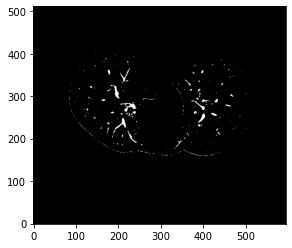

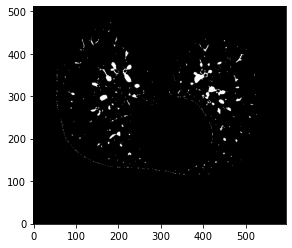

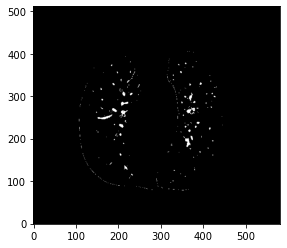

In [8]:
!echo "Specify denoise=False in create_vessel_mask for quick and noisy results."
!echo "Otherwise wait a couple of minutes :)"
vessels = './Vessels/'
figures = './Figures/'
overlay_path = './Vessel_overlayed/'
paths = sorted(glob.glob(basepath))
myFile = open('vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

make_dirs(vessels)
make_dirs(overlay_path)
make_dirs(figures)

def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels


def split_array_coords(array, indx=0, indy=1):
    x = [array[i][indx] for i in range(len(array))]
    y = [array[i][indy] for i in range(len(array))]
    return x, y


def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
    show_slice(vessels)

    return vessels


for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0].split('\\')[-1]
    vessel_name = vessels + img_name + "_vessel_only_mask"
    overlay_name = overlay_path + img_name + "_vessels"

    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    contours = intensity_seg(ct_numpy, -1000, -300)

    lungs_contour = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs_contour)

    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, denoise=True)

    overlay_plot(ct_numpy, vessels_only)
    plt.title('Overlayed plot')
    plt.savefig(overlay_name)
    plt.close()

    save_nifty(vessels_only, vessel_name, affine=ct_img.affine)

    vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
    ratio = (vessel_area / lung_area) * 100
    print(img_name, 'Vessel %:', ratio)
    lung_areas_csv.append([img_name, lung_area, vessel_area, ratio])
    ratios.append(ratio)

# Save data to csv file
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas_csv)


Centers 2D: [[15929.82793873   419.93958111]
 [31665.78977348   939.52288819]]
Slice labels: [0 1 1 1 1 1 0 1]


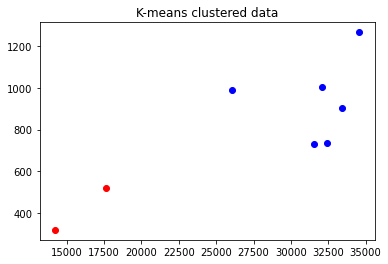

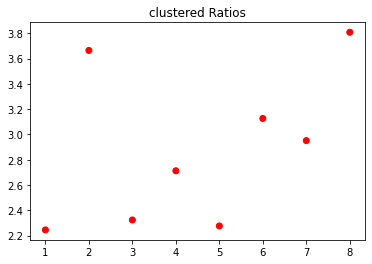

In [9]:
# Data viz here
from sklearn.cluster import KMeans
x, y = split_array_coords(lung_areas_csv, indx=1, indy=2)
data2d = np.stack([np.asarray(x), np.asarray(y)], axis=1)

kmeans = KMeans(init="random", n_clusters=2)
kmeans.fit(data2d)
print('Centers 2D:', kmeans.cluster_centers_)
print('Slice labels:', kmeans.labels_)

class1 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 0]
class2 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 1]

plt.figure()
x, y = split_array_coords(class1)
plt.scatter(x, y, c='r')
x, y = split_array_coords(class2)
plt.scatter(x, y, c='b')
plt.title('K-means clustered data')
plt.savefig('kmeans-clustered')

plt.figure()
x, _ = split_array_coords(lung_areas_csv, indx=3, indy=2)
plt.scatter(x, np.arange(len(x)))
plt.title('Ratios of different slices')
plt.savefig('./Ratios')
plt.close()

# assign categories
categories = np.zeros(len(x), dtype=int)

for c, i in enumerate(x):
    if i > 6:
        categories[c] = int(1)

colormap = np.array(['r', 'b'])

plt.figure()
plt.scatter(np.arange(len(x)) + 1, x, c=colormap[categories])
plt.title('clustered Ratios')
plt.savefig('./clustered_ratios')

In [10]:
def show_slice_window(slice, level, window):
   """
   Function to display an image slice
   Input is a numpy 2D array
   """
   max = level + window/2
   min = level - window/2
   slice = slice.clip(min,max)
   plt.figure()
   plt.imshow(slice.T, cmap="gray", origin="lower")
   plt.savefig('L'+str(level)+'W'+str(window))

In [11]:
exam_path = paths[1]
ct_img = nib.load(exam_path)
ct_numpy = ct_img.get_fdata()

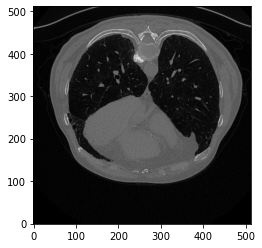

In [12]:
show_slice(ct_numpy)

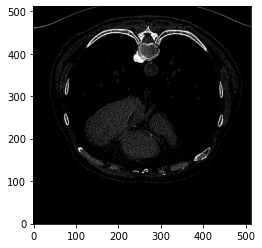

In [13]:
show_slice_window(ct_numpy, 250, 500)

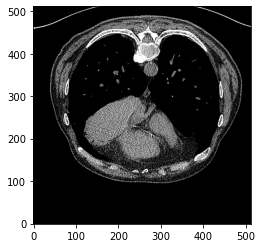

In [14]:
show_slice_window(ct_numpy, 50, 350)

In [15]:
import nibabel as nib
ct_img = nib.load(exam_path)
print(ct_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  2 512 512   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.78515625 0.78515625 1.         1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 206.60742
qoffset_y       : 405.60742
qoffset_z 

In [16]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    dim = ct_img.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

In [17]:
find_pix_dim(ct_img)

[0.78515625, 0.78515625]